### Stage 4 - IFRS 9 staging (PD-based SICR)

This notebook produces IFRS 9 stages using a PD-based SICR proxy:

- score a PD proxy (`pd_hat`) using the Stage 2 model
- define a proxy for origination PD as the median PD by `sub_grade`
- flag SICR using a PD ratio and PD delta rule
- assign stages (1/2/3)

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.makedirs("data", exist_ok=True)

# Configuration
DATA_PATH = "data/loans_stage3_enriched.csv"
OUT_PATH = "data/loans_stage4_staged.csv"
PD_MODEL_PATH = "models/pd_model_stage2_calibrated.joblib"
# SICR thresholds
RATIO_TH = 1.5
DELTA_TH = 0.07
EPS = 1e-6
print("SICR thresholds:", {"ratio": RATIO_TH, "delta": DELTA_TH})

SICR thresholds: {'ratio': 1.5, 'delta': 0.07}


In [ ]:
df = pd.read_csv(DATA_PATH)
df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")
df = df.dropna(subset=["issue_d"]).sort_values("issue_d").reset_index(drop=True)
needed = ["default_12m", "sample_weight", "term"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns from Stage 3: {missing}")
print("Rows:", len(df))
print("Issue date range:", df["issue_d"].min().date(), "->", df["issue_d"].max().date())
print("Default rate (proxy):", float(df["default_12m"].mean()))

Rows: 541736
Issue date range: 2011-01-01 -> 2016-12-01
Default rate (proxy): 0.3986683550659362


In [ ]:
def sub_grade_to_ord(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper()
    if len(s) < 2:
        return np.nan
    letter = s[0]
    num = s[1:]
    if letter < "A" or letter > "G":
        return np.nan
    try:
        n = int(num)
    except:
        return np.nan
    if n < 1 or n > 5:
        return np.nan
    return (ord(letter) - ord("A")) * 5 + n

def emp_length_to_ord(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["n/a", "na", "none", "nan", ""]:
        return np.nan
    if "<" in s:
        return 0
    if "10+" in s:
        return 10
    try:
        return int(s.split()[0])
    except:
        return np.nan

def term_to_num(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    digits = "".join([c for c in s if c.isdigit()])
    try:
        return int(digits)
    except:
        return np.nan

#Ensure expected engineered features exist
if "revol_credit" not in df.columns:
    df["revol_credit"] = df["open_acc"] * (df["revol_util"] / 100.0)

if "loan_to_income" not in df.columns:
    df["loan_to_income"] = np.where(df["annual_inc"] > 0, df["loan_amnt"] / df["annual_inc"], np.nan)

#Ordinal numeric features
df["term_num"] = df["term"].map(term_to_num)
df["sub_grade_ord"] = df["sub_grade"].map(sub_grade_to_ord)
df["emp_length_ord"] = df["emp_length"].map(emp_length_to_ord)

In [ ]:
pd_model = joblib.load(PD_MODEL_PATH)
#Build X using the same inputs that Stage 2 expects
PD_INPUTS = [
    "int_rate", "dti", "revol_util", "loan_to_income",
    "loan_amnt", "annual_inc", "delinq_2yrs", "open_acc", "pub_rec", "revol_credit",
    "term_num", "sub_grade_ord", "emp_length_ord",
    "purpose", "home_ownership", "verification_status",
]
missing = [c for c in PD_INPUTS if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns required for PD scoring: {missing}")
X = df[PD_INPUTS].copy()
df["pd_hat"] = pd_model.predict_proba(X)[:, 1]

print(df["pd_hat"].describe(percentiles=[0.1, 0.5, 0.9]))

count    541736.000000
mean          0.184726
std           0.099959
min           0.019447
10%           0.066846
50%           0.170036
90%           0.320851
max           0.929389
Name: pd_hat, dtype: float64


In [ ]:
# Proxy origination PD: median PD by sub_grade
df["pd_orig_proxy"] = df.groupby("sub_grade")["pd_hat"].transform("median")
df["pd_ratio"] = df["pd_hat"] / np.maximum(df["pd_orig_proxy"], EPS)
df["pd_delta"] = df["pd_hat"] - df["pd_orig_proxy"]
df["sicr_flag"] = (df["pd_ratio"] >= RATIO_TH) | (df["pd_delta"] >= DELTA_TH)
df["stage"] = 1
df.loc[df["sicr_flag"], "stage"] = 2
df.loc[df["default_12m"] == 1, "stage"] = 3

print("Stage distribution:")
print(df["stage"].value_counts(normalize=True).sort_index())
print("\nSICR rate among non-defaults:")
print(float(df.loc[df["default_12m"] == 0, "sicr_flag"].mean()))

Stage distribution:
stage
1    0.573789
2    0.027543
3    0.398668
Name: proportion, dtype: float64

SICR rate among non-defaults:
0.045803237322838995


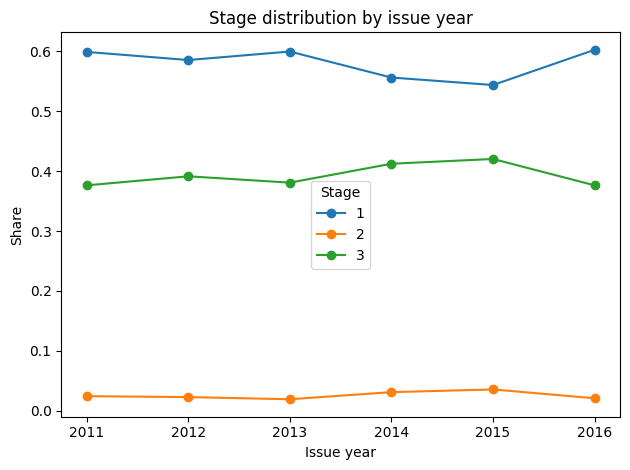

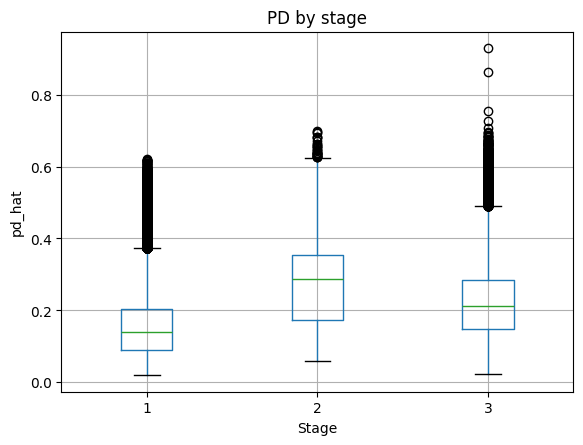

In [ ]:
#Stage mix over time (share of each stage per issue year)
stage_by_year = (df.assign(year=df["issue_d"].dt.year).groupby(["year", "stage"]).size().groupby(level=0).apply(lambda s: s / s.sum()).unstack(fill_value=0))

#Plot for stage distribution by year
stage_by_year_plot = stage_by_year.copy()
if isinstance(stage_by_year_plot.index, pd.MultiIndex):
    stage_by_year_plot.index = stage_by_year_plot.index.get_level_values(0)
stage_by_year_plot.index = stage_by_year_plot.index.astype(int)
ax = stage_by_year_plot.sort_index().plot(kind="line", marker="o")
ax.set_title("Stage distribution by issue year")
ax.set_ylabel("Share")
ax.set_xlabel("Issue year")
years = stage_by_year_plot.index.to_list()
ax.set_xticks(years)
ax.set_xticklabels([str(y) for y in years], rotation=0)
ax.legend(title="Stage")
plt.tight_layout()
plt.show()

#Plot for PD distribution by stage
df.boxplot(column="pd_hat", by="stage")
plt.title("PD by stage")
plt.suptitle("")
plt.xlabel("Stage")
plt.ylabel("pd_hat")
plt.show()

In [ ]:
#Use grade-segmented LGD by default
df["lgd_base_used"] = df["lgd_base_seg"]
df["lgd_downturn_used"] = df["lgd_downturn_seg"]
display(df[["ead_12m", "lgd_base_used", "lgd_downturn_used"]].describe())

,ead_12m,lgd_base_used,lgd_downturn_used
count,541736.000000,541736.000000,541736.000000
mean,11598.974451,0.397411,0.546440
std,7139.202732,0.065430,0.089967
min,684.196071,0.300000,0.412500
25%,5799.252013,0.350000,0.481250
50%,10308.143123,0.400000,0.550000
75%,16229.982640,0.450000,0.618750
max,35890.068275,0.580000,0.797500


In [ ]:
out_cols = [
    "issue_d",
    "term",
    "sample_weight",
    "default_12m",
    "pd_hat", "pd_orig_proxy", "pd_ratio", "pd_delta",
    "sicr_flag", "stage",
    "ead_6m", "ead_12m",
    "lgd_base_used", "lgd_downturn_used",
    "grade", "sub_grade", "purpose", "home_ownership", "verification_status",
    "loan_amnt", "annual_inc", "int_rate", "installment", "dti", "revol_util",
]
missing = [c for c in out_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns before export: {missing}")
df[out_cols].to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH, "| rows:", len(df))

Saved: data/loans_stage4_staged.csv | rows: 541736
